## 1. Set-up

In [1]:
import os,re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
# variable that allows load data faster
IMAGE_SIZE = [180,180]

ROOT_PATH = os.path.join(os.getenv('HOME'),'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


## 2. Load data

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f'Normal images count in training set :{COUNT_NORMAL}')

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f'Normal images count in training set :{COUNT_PNEUMONIA}')

Normal images count in training set :1072
Normal images count in training set :3113


In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [9]:
# Because there are no Label Data, create Label Data using filenames
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"

In [10]:
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) #transfer image to uint8 tensor
    img = tf.image.convert_image_dtype(img, tf.float32) #transfer image to float32
    img = tf.image.resize(img,IMAGE_SIZE) # resize image 
    return img

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img,label

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
for image, label in train_ds.take(1):
    print('Image shape : ',image.numpy().shape)
    print('Label : ',label.numpy())

Image shape :  (180, 180, 3)
Label :  False


In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path,num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [14]:
def prepare_for_training(ds,shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## 3. Visualize data

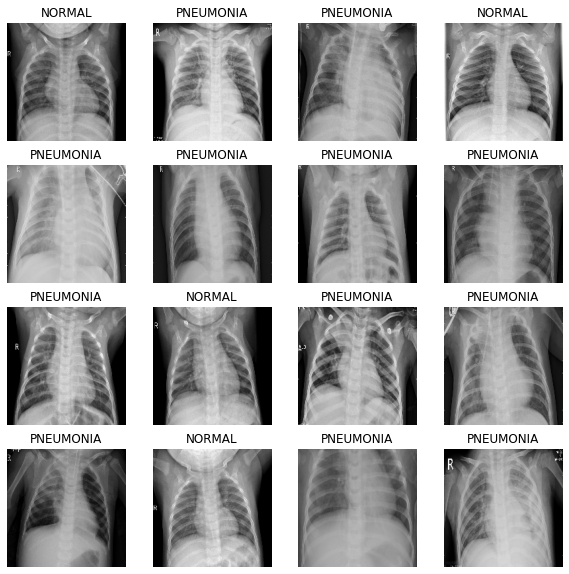

In [15]:
def show_batch(image_batch,label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title('PNEUMONIA')
        else:
            plt.title('NORMAL')
        plt.axis('off')
        

image_batch,label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(),label_batch.numpy())

## 4. CNN Modeling

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters,3,activation='relu',padding='same'),
        tf.keras.layers.SeparableConv2D(filters,3,activation='relu',padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [17]:
def dense_block(units,dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units,activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3)),
        
        tf.keras.layers.Conv2D(16,3,activation='relu',padding='same'),
        tf.keras.layers.Conv2D(16,3,activation='relu',padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512,0.7),
        dense_block(128,0.5),
        dense_block(64,0.3),
        
        tf.keras.layers.Dense(1,activation='sigmoid')
    ])
    
    return model

## 5. Data imbalance processing

In [18]:
weight_for_0 = (1/COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1/COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0:weight_for_0,1:weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


## 6. Training Model

In [20]:
with tf.device('/GPU:0'):
    model = build_model()
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [21]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 63s 194ms/step - loss: 0.4075 - accuracy: 0.7886 - precision: 0.9524 - recall: 0.7536 - val_loss: 0.6085 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 50s 193ms/step - loss: 0.2484 - accuracy: 0.9013 - precision: 0.9716 - recall: 0.8935 - val_loss: 1.5600 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 51s 195ms/step - loss: 0.2089 - accuracy: 0.9193 - precision: 0.9779 - recall: 0.9122 - val_loss: 0.9343 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 51s 196ms/step - loss: 0.1696 - accuracy: 0.9341 - precision: 0.9816 - recall: 0.9289 - val_loss: 0.2351 - val_accuracy: 0.9010 - val_precision: 0.8809 - val_recall: 1.0000
Epoch 5/25
261/261 [==============================] - 52s 201ms/step - loss: 0.1709 - accura

## 7. Results

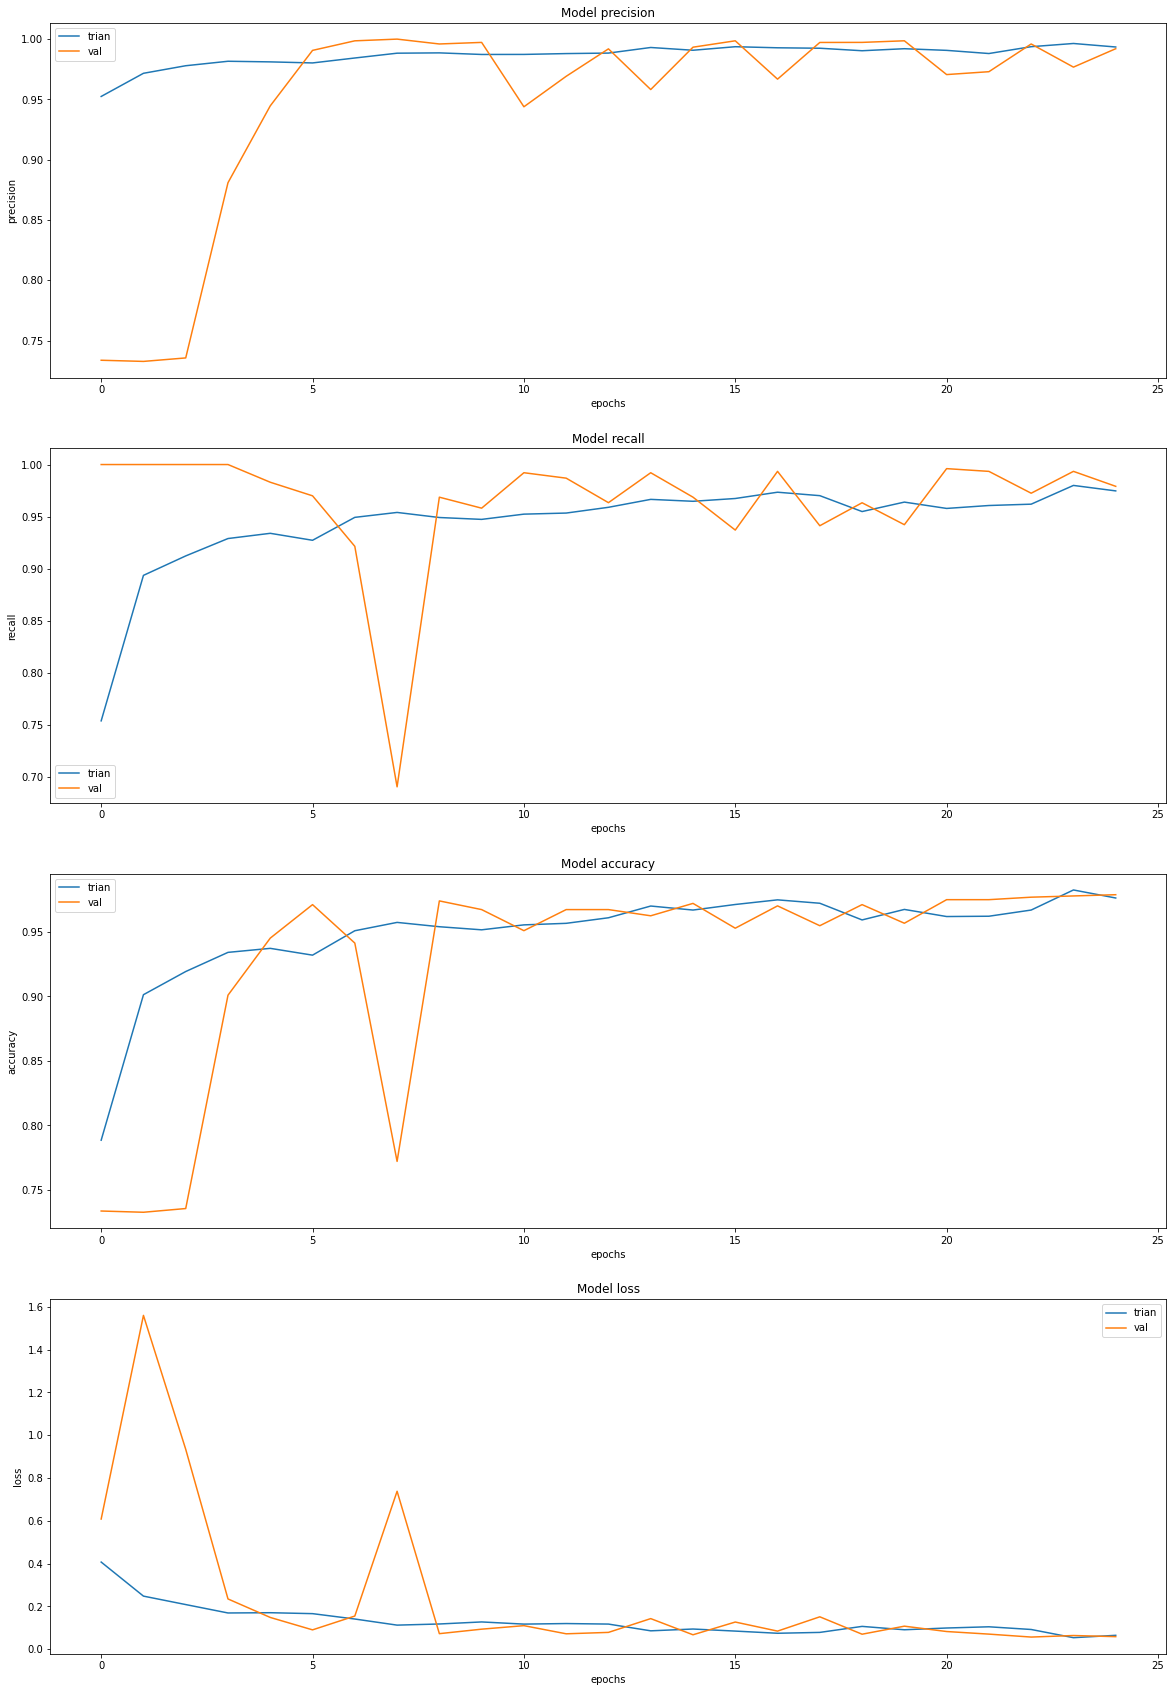

In [22]:
fig, ax = plt.subplots(4,1,figsize=(20,30))
ax = ax.ravel()

for i, met in enumerate(['precision','recall','accuracy','loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_'+met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['trian','val'])

In [23]:
loss,accuracy,precision,recall = model.evaluate(test_ds)
print(f'Loss:{loss},\nAccuracy: {accuracy},\nPrecision:{precision},\nRecall:{recall}')

39/39 [==============================] - 4s 111ms/step - loss: 1.3255 - accuracy: 0.7981 - precision: 0.7598 - recall: 0.9897
Loss:1.3254878520965576,
Accuracy: 0.7980769276618958,
Precision:0.7598425149917603,
Recall:0.9897435903549194


## 8. Improve Performance

### *change Batch size or Epoch*

In [19]:
BATCH_SIZE = 32
EPOCHS = 25

### *data agumentation*

In [ ]:
# def augment(image,label):
#     image = tf.image.random_flip_left_right(image)
#     return image,label

# def prepare_for_training(ds, shuffle_buffer_size=1000):
#     ds = ds.map(
#             augment,       
#             num_parallel_calls=2
#         )
#     ds = ds.shuffle(buffer_size=shuffle_buffer_size)
#     ds = ds.repeat()
#     ds = ds.batch(BATCH_SIZE)
#     ds = ds.prefetch(buffer_size=AUTOTUNE)

#     return ds

# train_ds = prepare_for_training(train_ds)
# val_ds = prepare_for_training(val_ds)

In [ ]:
# image_batch,label_batch = next(iter(train_ds))
# show_batch(image_batch.numpy(),label_batch.numpy())

In [26]:
def augment_block():
    block = tf.keras.Sequential([
      tf.keras.layers.RandomFlip("horizontal_and_vertical"),
      tf.keras.layers.RandomRotation(0.2),
    ])
    
    return block

In [27]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3)),
        
        augment_block(),
        
        tf.keras.layers.Conv2D(16,3,activation='relu',padding='same'),
        tf.keras.layers.Conv2D(16,3,activation='relu',padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512,0.7),
        dense_block(128,0.5),
        dense_block(64,0.3),
        
        tf.keras.layers.Dense(1,activation='sigmoid')
    ])
    
    return model

In [28]:
with tf.device('/GPU:0'):
    model = build_model()
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [30]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
130/130 [==============================] - 42s 225ms/step - loss: 0.7242 - accuracy: 0.6245 - precision: 0.8507 - recall: 0.6041 - val_loss: 0.6450 - val_accuracy: 0.7617 - val_precision: 0.7617 - val_recall: 1.0000
Epoch 2/25
130/130 [==============================] - 29s 227ms/step - loss: 0.4822 - accuracy: 0.7702 - precision: 0.9324 - recall: 0.7435 - val_loss: 0.6718 - val_accuracy: 0.7480 - val_precision: 0.7480 - val_recall: 1.0000
Epoch 3/25
130/130 [==============================] - 29s 226ms/step - loss: 0.4363 - accuracy: 0.7962 - precision: 0.9437 - recall: 0.7742 - val_loss: 0.7488 - val_accuracy: 0.7578 - val_precision: 0.7578 - val_recall: 1.0000
Epoch 4/25
130/130 [==============================] - 30s 234ms/step - loss: 0.3704 - accuracy: 0.8356 - precision: 0.9509 - recall: 0.8198 - val_loss: 1.0694 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 5/25
130/130 [==============================] - 31s 242ms/step - loss: 0.3285 - accura

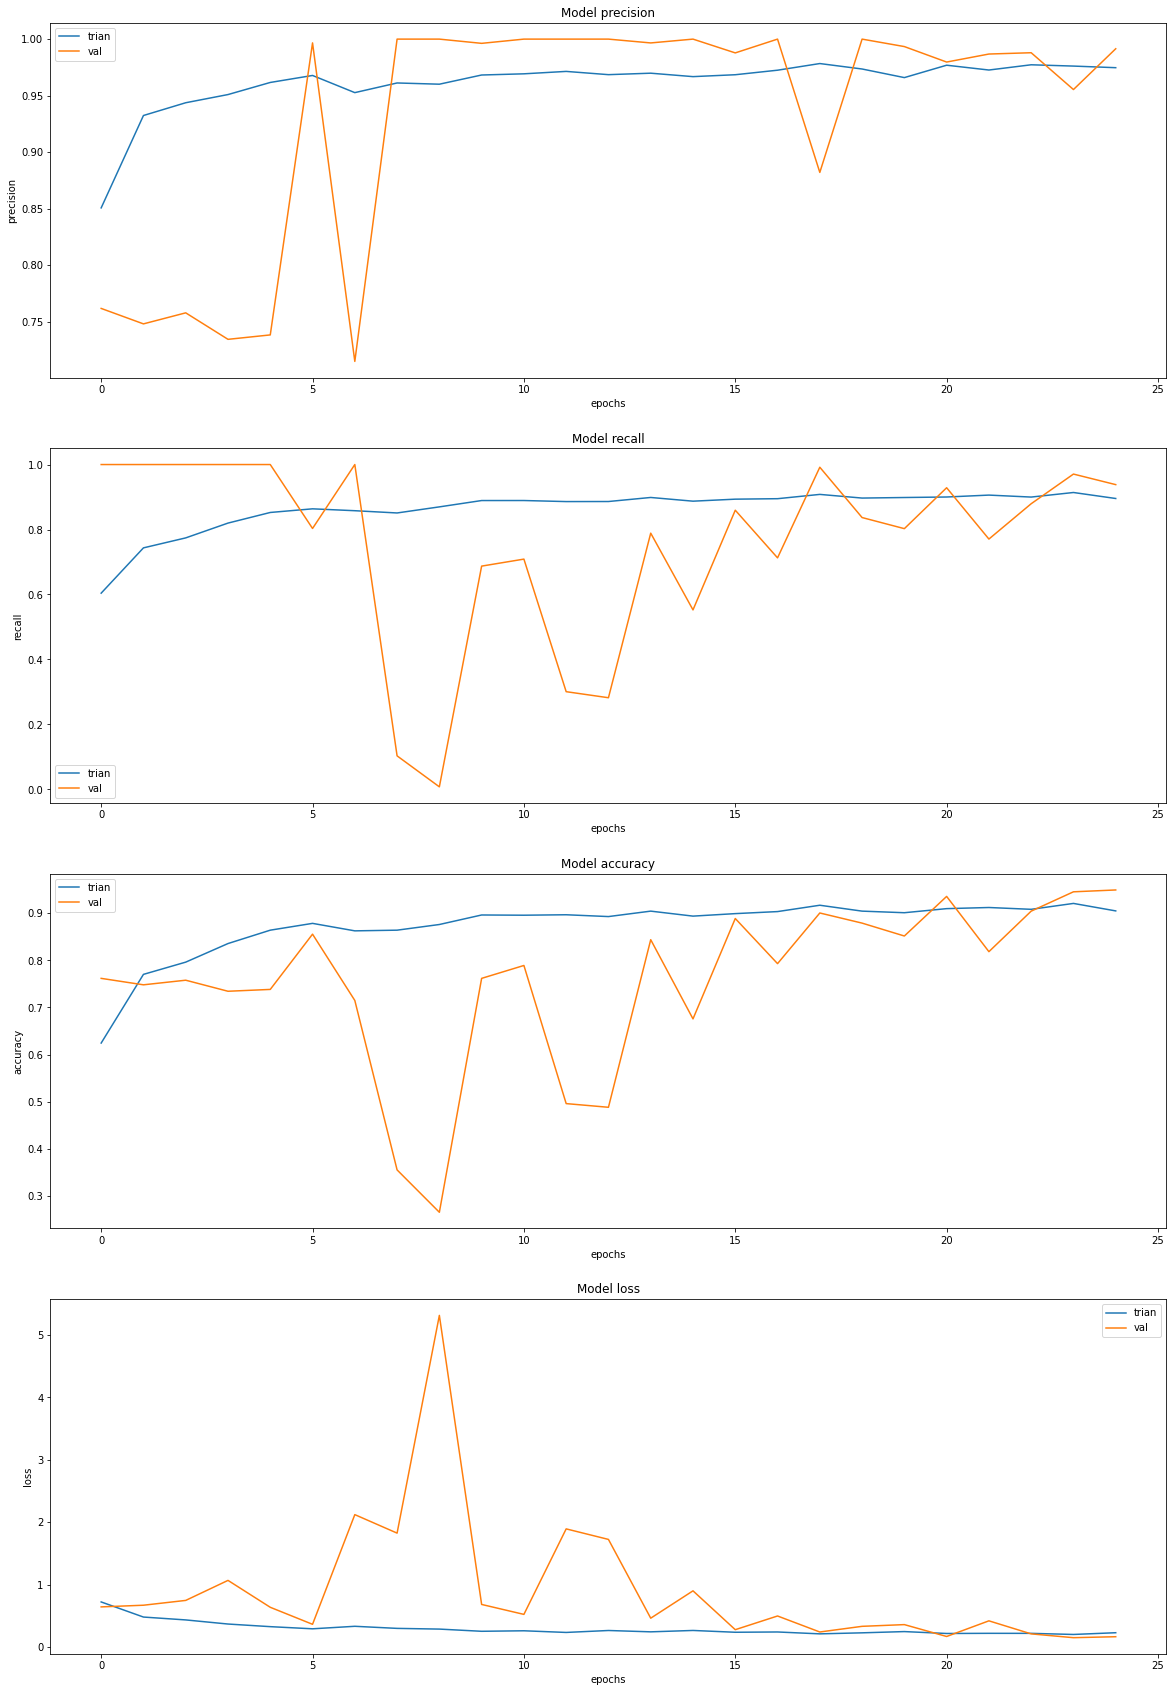

In [31]:
fig, ax = plt.subplots(4,1,figsize=(20,30))
ax = ax.ravel()

for i, met in enumerate(['precision','recall','accuracy','loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_'+met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['trian','val'])

In [32]:
loss,accuracy,precision,recall = model.evaluate(test_ds)
print(f'Loss:{loss},\nAccuracy: {accuracy},\nPrecision:{precision},\nRecall:{recall}')

39/39 [==============================] - 5s 115ms/step - loss: 0.3277 - accuracy: 0.8638 - precision: 0.8588 - recall: 0.9359
Loss:0.32771408557891846,
Accuracy: 0.8637820482254028,
Precision:0.8588235378265381,
Recall:0.9358974099159241


###  performance improvement : accuracy : 0.79 -> 0.86 으로 상승 
- batch size 32 로 조정
- data augmentation 사용 

*data augmentation 사용할 때, 주석처리된 코드를 사용 할 경우 모델에서 expected dimension 은 4 이지만 5로 늘어나서 apply 할 수 없는 상황이 발생했다.
근본적인 해결 방법은 찾지 못했지만, data 를 augmentation 한 뒤 모델에 넣지 않고, 모델안에 augmentation layer 를 넣어 주는 방식으로 해결하였다.*

*data augmentation이 잘 되었는지 확인 하는 용도로 노드에서 show_batch 함수를 사용할 것을 제시 했지만, 메모리를 초과하는 문제가 발생했다. 
다른방식으로 확인 하는 방법을 찾으려 했으나, 현재 image 를 flip 하는 augmentation만 사용하기 때문에 시각화 하는 것이 큰 의미가 없다고 판단하여 아예 사용하지 않았다.*